## Atividade 03 - Parte 01

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image, display

#### Função para determinar a classe de estabilidade de Pasquill

In [2]:
def pasquill(periodo):
    if periodo=='dia':
        # Gerando valor aleatório para radiação solar (Monte-Carlo)
        solar = np.random.rand(1)
        Max = 1000
        Min = 200
        solar = (Max-Min)*solar + Min
        # Gerando valor aleatório para velocidade do vento (Monte-Carlo)
        vento = np.random.rand(1)
        Max = 10
        Min = 0
        vento = (Max-Min)*vento + Min
        return {'Radiação solar (W/m2)': [solar[0]], 
                'Velocidade do vento (m/s)': [vento[0]]} 
    if periodo=='noite':
        # Gerando valor aleatório para cobertura de nuvens
        nuvens = np.random.randint(0,9)
        # Gerando valor aleatório para velocidade do vento (Monte-Carlo)
        vento = np.random.rand(1)
        Max = 10
        Min = 2
        vento = (Max-Min)*vento + Min
        return {'Cobertura de nuvens': [str(nuvens)+'/8'], 
                'Velocidade do vento (m/s)': [vento[0]]} 

### Função de estimativa de coeficiente de dispersão (sigmaYZ) para todas as classes de estabilidade

In [33]:
# Função para estimar as dispersões lateral e vertical da pluma 
def sigmasYZ(UR, classe, x):
    if (classe=='A' or classe=='B') and UR=='urbano':
        sigmaY = 0.32*x*((1+0.0004*x)**(-0.5)) 
        sigmaZ = 0.24*x*((1+0.001*x)**(0.5)) 
    if classe=='C' and UR=='urbano':
        sigmaY = 0.22*x*((1+0.0004*x)**(-0.5)) 
        sigmaZ = 0.20*x 
    if classe=='D' and UR=='urbano':
        sigmaY = 0.16*x*((1+0.0004*x)**(-0.5)) 
        sigmaZ = 0.14*x*((1+0.0003*x)**(-0.5))
    if (classe=='E' or classe=='F') and UR=='urbano':
        sigmaY = 0.11*x*((1+0.0004*x)**(-0.5)) 
        sigmaZ = 0.08*x*((1+0.0015*x)**(-0.5)) 
    if classe=='A' and UR=='rural':
        sigmaY = 0.22*x*((1+0.0001*x)**(-0.5)) 
        sigmaZ = 0.20*x 
    if classe=='B' and UR=='rural':
        sigmaY = 0.16*x*((1+0.0001*x)**(-0.5))
        sigmaZ = 0.12*x      
    if classe=='C' and UR=='rural':
        sigmaY = 0.11*x*((1+0.0001*x)**(-0.5))
        sigmaZ = 0.08*x*((1+0.0002*x)**(-0.5))           
    if classe=='D' and UR=='rural':
        sigmaY = 0.08*x*((1+0.0001*x)**(-0.5))
        sigmaZ = 0.06*x*((1+0.0015*x)**(-0.5))      
    if classe=='E' and UR=='rural':
        sigmaY = 0.06*x*((1+0.0001*x)**(-0.5))
        sigmaZ = 0.03*x*((1+0.0003*x)**(-1))
    if classe=='F' and UR=='rural':
        sigmaY = 0.04*x*((1+0.0001*x)**(-0.5))
        sigmaZ = 0.016*x*((1+0.0003*x)**(-1))
    return float(sigmaY), float(sigmaZ)

### Função de estimativa de sobrelevação da pluma

In [4]:
# Gerando valores aleatórios para u, Vs & Ts (Monte-Carlo)
def variaveis():
    u = np.random.rand(1) # velocidade do vento na altura da chaminé
    Max = 10
    Min = 0
    u = (Max-Min)*u + Min
    Vs = np.random.rand(1) # velocidade dos gases na saída da chaminé
    Max = 10
    Min = 0
    Vs = (Max-Min)*Vs + Min
    Ts = np.random.rand(1) # temperatura dos gases na saída da chaminé 
    Max = 700
    Min = 400
    Ts = (Max-Min)*Ts + Min
    return{'Velocidade do vento (m/s)': [u[0]], 
           'Velocidade dos gases (m/s)': [Vs[0]], 
           'Temperatura dos gases (K)': [Ts[0]], 
           'Diâmetro da chaminé (m)': [1]} 

In [5]:
# Método de Davidson-Bryant 
def bryant(u, vs, ts, d):
    deltaH = d*((vs/u)**1.4)*(1+((ts-300)/ts))
    return deltaH 

In [6]:
# Método de Holland
def holland(u, vs, ts, d, classe):
    deltaH = (vs*d/u)*(1.5+(0.00268*1013*(ts-300)*d/ts))
    if classe=='A' or classe=='B' or classe=='C': # condições instáveis 
        deltaH = 1.15*deltaH # acréscimo de 15%
    else:
        deltaH = 0.85*deltaH # decréscimo de 15% 
    return deltaH 

In [7]:
# Análise do efeito Tip-Downwash e cálculo da altura efetiva
def Hef(Hg, dH, vs, u, d):
    if vs<(1.5*u):
        Hefetiva = Hg + (2*d*((vs/u)-1.5)) + dH 
    else:
        Hefetiva = Hg + dH
    return Hefetiva 

In [29]:
def modeloGaussiano(qs, sigmaY, sigmaZ, u, y, z, H):
    # Converte sigmaY e sigmaZ para números individuais, se necessário
    sigmaY = sigmaY[0] if isinstance(sigmaY, list) else sigmaY
    sigmaZ = sigmaZ[0] if isinstance(sigmaZ, list) else sigmaZ
    
    termo1 = qs/(2*np.pi*sigmaY*sigmaZ*u)
    termo2 = np.exp((-y**2)/(2*sigmaY**2))
    termo3 = np.exp((-(z-H)**2)/(2*sigmaZ**2)) + np.exp((-(z+H)**2)/(2*sigmaZ**2))
    conc = termo1*termo2*termo3
    conc = conc*10**6
    return conc # micro g/m3 

### Simulações com o script

##### CONAMA 491/2018 
https://www.in.gov.br/web/guest/materia/-/asset_publisher/Kujrw0TZC2Mb/content/id/51058895/do1-2018-11-21-resolucao-n-491-de-19-de-novembro-de-2018-51058603

In [9]:
df = pd.DataFrame(data=pasquill('dia'))
df

,Radiação solar (W/m2),Velocidade do vento (m/s)
0,362.032805,9.208448


In [11]:
Classe = 'A'

In [12]:
sigmas = pd.DataFrame(data=sigmasYZ('urbano', Classe, 100)) 
sigmas

,Sigma Y,Sigma Z
0,31.378582,25.171412


In [13]:
dados = pd.DataFrame(data=variaveis())   
dados

,Velocidade do vento (m/s),Velocidade dos gases (m/s),Temperatura dos gases (K),Diâmetro da chaminé (m)
0,2.638716,1.18998,450.350433,1


In [14]:
dH1 = bryant(dados['Velocidade do vento (m/s)'][0],
            dados['Velocidade dos gases (m/s)'][0],
            dados['Temperatura dos gases (K)'][0],
            dados['Diâmetro da chaminé (m)'][0])
dH1

0.4374347804810839

In [15]:
dH2 = holland(dados['Velocidade do vento (m/s)'][0],
              dados['Velocidade dos gases (m/s)'][0],
              dados['Temperatura dos gases (K)'][0],
              dados['Diâmetro da chaminé (m)'][0], 
              Classe)
dH2

1.2479707970944658

In [16]:
HG = 25.0
HEF = Hef(HG, 
      dH2, 
      dados['Velocidade dos gases (m/s)'][0], 
      dados['Velocidade do vento (m/s)'][0], 
      dados['Diâmetro da chaminé (m)'][0])
HEF

24.149909201646793

In [17]:
# OBS: nossas medias anuais em g/s:
# PM = 131.772771	
# PM-10	= 21.409322
# NOX = 1.393929	
# CO = 50.354440	
# VOC as propane = 84.648386  		

In [18]:
QS = 1.393929 # media NOX (anual) - (g/s)
Y = 1
Z = 1
Conc = modeloGaussiano(QS,
                       sigmas['Sigma Y'][0],
                       sigmas['Sigma Z'][0],
                       dados['Velocidade do vento (m/s)'][0],
                       Y,
                       Z,
                       HEF) 
Conc # micro g/m3
#Limite CONAMA 491 = 40 micro g/m3

134.2854416264244

### Simulações para diferentes níveis de estabilidade da atmosfera

##### Condição = instável (Pasquill E)

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#definição de parâmetros utilizando dados da Atividade01
classe= 'E'
y = 0 #direção do vento
z = 1.60 #m 
UR = 'urbano'
u = 7 #m/s
H = 50 #m, altura da chaminé 
diam = 1 #m, diâmetro da chaminé
V = 9 #m/s, velocidade dos gases
T = 525 #K, temperatura dos gases
x = np.arange(1, 6001, 100)

#listas para armazenar resultados
resultados = []
resultPM = []
resultPM10 = []
resultNOX = []
resultCO =[]
resultVOC = []

#somatória da média dos poluentes calculados na Atividade 01
qs = 0.135+0.0219+0.00057+0.052+0.0385
#média de cada poluente
PM = 0.135
PM10 = 0.0219
NOX = 0.00057
CO = 0.052
VOC = 0.0385
#gerando os valores utilizando as funções pré-definidas
for valor_x in x:
    sigmaY, sigmaZ = sigmasYZ(UR, classe, valor_x)
    if sigmaY != 0 and sigmaZ != 0:
        conc = modeloGaussiano (qs, sigmaY, sigmaZ, u, y, z, H)
        resultados.append(conc)        
for valor_x in x:
    sigmaY, sigmaZ = sigmasYZ(UR, classe, valor_x)
    if sigmaY != 0 and sigmaZ != 0:
        conc = modeloGaussiano (PM, sigmaY, sigmaZ, u, y, z, H)
        resultPM.append(conc) 
for valor_x in x:
    sigmaY, sigmaZ = sigmasYZ(UR, classe, valor_x)
    if sigmaY != 0 and sigmaZ != 0:
        conc = modeloGaussiano (PM10, sigmaY, sigmaZ, u, y, z, H)
        resultPM10.append(conc) 
for valor_x in x:
    sigmaY, sigmaZ = sigmasYZ(UR, classe, valor_x)
    if sigmaY != 0 and sigmaZ != 0:
        conc = modeloGaussiano (NOX, sigmaY, sigmaZ, u, y, z, H)
        resultNOX.append(conc) 
for valor_x in x:
    sigmaY, sigmaZ = sigmasYZ(UR, classe, valor_x)
    if sigmaY != 0 and sigmaZ != 0:
        conc = modeloGaussiano (CO, sigmaY, sigmaZ, u, y, z, H)
        resultCO.append(conc) 
for valor_x in x:
    sigmaY, sigmaZ = sigmasYZ(UR, classe, valor_x)
    if sigmaY != 0 and sigmaZ != 0:
        conc = modeloGaussiano (VOC, sigmaY, sigmaZ, u, y, z, H)
        resultVOC.append(conc) 

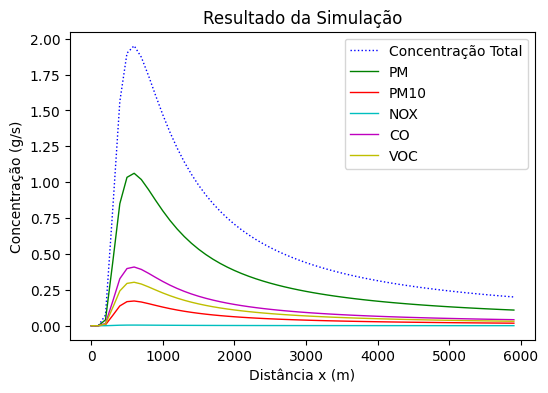

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plotagem dos resultados
plt.figure(figsize=(6, 4))

plt.plot(x, resultados, linestyle=':', color='b', label='Concentração Total', linewidth = 1)
plt.plot(x, resultPM, linestyle='-', color='g', label='PM', linewidth = 1)
plt.plot(x, resultPM10, linestyle='-', color='r', label='PM10', linewidth = 1)
plt.plot(x, resultNOX, linestyle='-', color='c', label='NOX', linewidth = 1)
plt.plot(x, resultCO, linestyle='-', color='m', label='CO', linewidth = 1)
plt.plot(x, resultVOC, linestyle='-', color='y', label='VOC', linewidth = 1)

plt.xlabel('Distância x (m)')
plt.ylabel('Concentração (g/s)')
plt.title('Resultado da Simulação')
plt.grid(False)
plt.legend()
plt.show()

##### Condição = estável (Pasquill A)

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#definição de parâmetros utilizando dados da Atividade01
classe= 'A'
y = 0 #direção do vento
z = 1.60 #m 
UR = 'urbano'
u = 1 #m/s
H = 50 #m, altura da chaminé 
diam = 1 #m, diâmetro da chaminé
V = 9 #m/s, velocidade dos gases
T = 525 #K, temperatura dos gases
x = np.arange(1, 6001, 100)

#listas para armazenar resultados
resultados = []
resultPM = []
resultPM10 = []
resultNOX = []
resultCO =[]
resultVOC = []

#somatória da média dos poluentes calculados na Atividade 01
qs = 0.135+0.0219+0.00057+0.052+0.0385
#média de cada poluente
PM = 0.135
PM10 = 0.0219
NOX = 0.00057
CO = 0.052
VOC = 0.0385
#gerando os valores utilizando as funções pré-definidas
for valor_x in x:
    sigmaY, sigmaZ = sigmasYZ(UR, classe, valor_x)
    if sigmaY != 0 and sigmaZ != 0:
        conc = modeloGaussiano (qs, sigmaY, sigmaZ, u, y, z, H)
        resultados.append(conc)        
for valor_x in x:
    sigmaY, sigmaZ = sigmasYZ(UR, classe, valor_x)
    if sigmaY != 0 and sigmaZ != 0:
        conc = modeloGaussiano (PM, sigmaY, sigmaZ, u, y, z, H)
        resultPM.append(conc) 
for valor_x in x:
    sigmaY, sigmaZ = sigmasYZ(UR, classe, valor_x)
    if sigmaY != 0 and sigmaZ != 0:
        conc = modeloGaussiano (PM10, sigmaY, sigmaZ, u, y, z, H)
        resultPM10.append(conc) 
for valor_x in x:
    sigmaY, sigmaZ = sigmasYZ(UR, classe, valor_x)
    if sigmaY != 0 and sigmaZ != 0:
        conc = modeloGaussiano (NOX, sigmaY, sigmaZ, u, y, z, H)
        resultNOX.append(conc) 
for valor_x in x:
    sigmaY, sigmaZ = sigmasYZ(UR, classe, valor_x)
    if sigmaY != 0 and sigmaZ != 0:
        conc = modeloGaussiano (CO, sigmaY, sigmaZ, u, y, z, H)
        resultCO.append(conc) 
for valor_x in x:
    sigmaY, sigmaZ = sigmasYZ(UR, classe, valor_x)
    if sigmaY != 0 and sigmaZ != 0:
        conc = modeloGaussiano (VOC, sigmaY, sigmaZ, u, y, z, H)
        resultVOC.append(conc) 

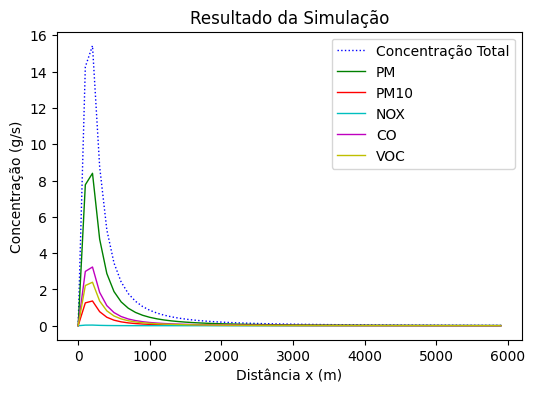

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plotagem dos resultados
plt.figure(figsize=(6, 4))

plt.plot(x, resultados, linestyle=':', color='b', label='Concentração Total', linewidth = 1)
plt.plot(x, resultPM, linestyle='-', color='g', label='PM', linewidth = 1)
plt.plot(x, resultPM10, linestyle='-', color='r', label='PM10', linewidth = 1)
plt.plot(x, resultNOX, linestyle='-', color='c', label='NOX', linewidth = 1)
plt.plot(x, resultCO, linestyle='-', color='m', label='CO', linewidth = 1)
plt.plot(x, resultVOC, linestyle='-', color='y', label='VOC', linewidth = 1)

plt.xlabel('Distância x (m)')
plt.ylabel('Concentração (g/s)')
plt.title('Resultado da Simulação')
plt.grid(False)
plt.legend()
plt.show()